# Horizontal bar graph I

In [1]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!pip install -q pytesseract


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp39-cp39-linux_x86_64.whl size=44089 sha256=9cb88a694eb21d5cc771a12c84edb8354a0a5149678789b3561e0d0bcc2f925a
  Stored in directory: /root/.cache/pip/wheels/68/be/8f/b6c454cd264e0b349b47f8ee00755511f277618af9e5dae20d
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.6.8 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.

In [2]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 92.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 17.4 MB/s eta 0:00:0

In [3]:
!sudo apt-get install tesseract-ocr


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 kB in 0s (10.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/Fron

In [4]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import numpy as np
from skimage.filters import frangi
from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2ForTokenClassification
from datasets import load_dataset
import pytesseract
from PIL import Image, ImageFont, ImageDraw


### function definations

In [6]:
def calc_contours(image_path):
  img = cv2.imread(image_path)

  # Apply bilateral filter
  img_bilateral = cv2.bilateralFilter(img, 9, 75, 75)

  # Convert the image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Apply thresholding to remove text and noise
  _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

  # Apply ROI masking to exclude non-graph regions
  mask = np.zeros_like(thresh)
  mask[50:400, 100:700] = 255
  masked_thresh = cv2.bitwise_and(thresh, mask)

  # Apply edge detection using the Canny algorithm
  edges = cv2.Canny(gray, 100, 200)

  # Apply horizontal line detection using HoughLinesP
  lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=250, maxLineGap=15)
  horizontal_lines = []
  for line in lines:
      x1, y1, x2, y2 = line[0]
      if abs(y1 - y2) < 5: # Check if the line is horizontal
          horizontal_lines.append(line)

  # Draw the detected lines on the image
  for line in horizontal_lines:
      x1, y1, x2, y2 = line[0]
      # cv2.line(img, (x1, y1), (x2, y2), (255, 255, 255), 2)

  # Find contours in the image
  contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # Filter out unwanted contours based on contour area and aspect ratio
  bars = []
  for cnt in contours:
      area = cv2.contourArea(cnt)
      x, y, w, h = cv2.boundingRect(cnt)
      aspect_ratio = float(w) / h
      if area > 7 and aspect_ratio > 5 and aspect_ratio < 50000:
          bars.append(cnt)

  ###### 2 consecutive element from the bars represent single contour only
  ###### and we will consider only one of them, so we will filter out odd index elemnts from the "bars"

  def filter_bars(bars):
    lst = []
    for i in range(len(bars)):
      if(i%2==1):
        lst.append(bars[i])
    return lst

  bars = filter_bars(bars)

  # Draw the remaining contours on the image
  cv2.drawContours(img, bars, -1, (255, 255, 0), 2)

  # Show the image
  cv2_imshow(img)
  return bars



In [7]:
def get_topright_corner(bars):
  topright_corner = []
  for bar in bars: 
    x, y, w, h = cv2.boundingRect(bar)
    topright_corner.append([x+w,y])
  return topright_corner

# contours_right_coords

In [8]:


def loadFromLayoutlmv2():
  feature_extractor = LayoutLMv2FeatureExtractor.from_pretrained("microsoft/layoutlmv2-base-uncased")# apply_ocr is set to True by default
  tokenizer = LayoutLMv2TokenizerFast.from_pretrained("microsoft/layoutlmv2-base-uncased") 
  model = LayoutLMv2ForTokenClassification.from_pretrained("nielsr/layoutlmv2-finetuned-funsd")
  return feature_extractor,tokenizer,model

def labelForBoxes():
  dataset = load_dataset("nielsr/funsd", split="test")
  # define id2label, label2color
  labels = dataset.features['ner_tags'].feature.names
  id2label = {v: k for v, k in enumerate(labels)}
  label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}
  return id2label, label2color

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

def process_image(image,id2label,label2color,feature_extractor,tokenizer,model):
    
    # Convert the image to RGB format
    image = image.convert('RGB')
    width, height = image.size

    # get words, boxes
    encoding_feature_extractor = feature_extractor(image, return_tensors="pt")
    words, boxes = encoding_feature_extractor.words, encoding_feature_extractor.boxes
    # encode
    encoding = tokenizer(words, boxes=boxes, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping')
    encoding["image"] = encoding_feature_extractor.pixel_values
    # forward pass
    outputs = model(**encoding)
    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()
    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]
    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction).lower()
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
    return image,true_boxes,words,true_predictions,true_boxes,is_subword


In [9]:
######## scaled data #############


def normalize_bbox(bboxes,img):
  # removing the fist and last coordinates
  bboxes= bboxes[1:-1]
  
  # Define the new image size
  new_width = 100
  new_height = 100

  original_width,original_height = img.size
  # Calculate the scaling factors
  x_scale = new_width / original_width
  y_scale = new_height / original_height

  #parsing the bboxes
  new_bboxes = []
  for bbox in bboxes:
    x1,y1,x2,y2 = bbox
    # Normalize the bounding box coordinates
    new_x1 = int(x1 * x_scale)
    new_y1 = int(y1 * y_scale)
    new_x2 = int(x2 * x_scale)
    new_y2 = int(y2 * y_scale)

    new_bbox = new_x1,new_y1,new_x2,new_y2
    new_bboxes.append(new_bbox)
  return new_bboxes


In [10]:
######### categorize the words into "keys, values, headers"

def graph_categorizer(words,bboxes,img):
  
  output_dict = {"headers":[],"keys":[],"values":[]}

  bboxes = normalize_bbox(bboxes,img)
  
  for idx in range(len(words[0])):
    x1,y1,x2,y2 = bboxes[idx]
    ###### header
    if(y2<=13):
      output_dict['headers'].append(words[0][idx])
    ###### keys
    elif(x2<43):
      output_dict['keys'].append(words[0][idx])    
    ###### values
    elif(x2>=43):
      output_dict['values'].append(words[0][idx])
  
  return output_dict


In [11]:
import re

def is_numeric_adv(text):
  pattern = r'\d+\.?\d+'  # regular expression pattern to match numerical values

  matches = re.findall(pattern, text)  # find all numerical values in the text string
  
  if(len(matches)):
    return True
  return False


In [12]:
######## merge close words

def merge_close_words(words,bboxes,image):

  
  nbboxes = normalize_bbox(bboxes,image)
  categorized_text = graph_categorizer(words,bboxes,image)

  words_to_bbox = {}
  bboxes = bboxes[1:-1]
  for idx in range(len(words[0])):
    if(words[0][idx] in categorized_text['headers']  or words[0][idx] in categorized_text['keys']):
      if(words[0][idx] in list(words_to_bbox.keys())):
        continue
      words_to_bbox[words[0][idx]] = bboxes[idx]  
  # print(words_to_bbox)
  
  parsed_idx = []
  parsed_words = []
  for idx in range(len(words[0])):
    if(idx in parsed_idx or words[0][idx] in parsed_words):
      continue
    if((words[0][idx] in categorized_text['headers']  or words[0][idx] in categorized_text['keys']) and (is_numeric_adv(words[0][idx])==False)):
      x1,y1,x2,y2 = nbboxes[idx]
      # print([words[0][idx]], nbboxes[idx])
      parsed_words.append(words[0][idx])
      ori_x1,ori_y1,ori_x2,ori_y2 = words_to_bbox[words[0][idx]]

      lower_10th_no = (y2//10) * 10
      higher_10th_no = lower_10th_no + 10

      # print(lower_10th_no , words[0][idx],y2)

      if(idx+4<len(words[0])):
        end_bound = idx+4
      else:
        end_bound = len(words[0]) 
      
      new_word = words[0][idx]
      for idx2 in range(idx+1,idx+4):

        x1_d,y1_d,x2_d,y2_d = nbboxes[idx2]
        

        lower_10th_no_d = (y2_d//10) * 10
        # print(lower_10th_no_d , words[0][idx2],y2_d)
        if(lower_10th_no_d == lower_10th_no):
          parsed_idx.append(idx)
          parsed_idx.append(idx2)
          parsed_idx =  list(set(parsed_idx))
          new_word = new_word + " " +  words[0][idx2]
          ori_x1_d,ori_y1_d,ori_x2_d,ori_y2_d = words_to_bbox[words[0][idx2]]
      # print(new_word)

      if(new_word in list(words_to_bbox.keys())):
        continue
      else:
        new_bbox = ori_x1,ori_y1, ori_x2_d,ori_y2_d
        
        ### delete the words that are now concatenated into new word
        keys = list(words_to_bbox.keys())
        for k in keys:
          if(k in new_word):
            # print('deleted',k)
            del words_to_bbox[k]
        
        #### add the concatenated word
        words_to_bbox[new_word] = [ori_x1,ori_y1, ori_x2_d,ori_y2_d]

      # words_to_bbox[]
  
  # bboxes = bboxes[1:-1]
  for idx in range(len(words[0])):
    # print('word', words[0][idx], bboxes[idx] )
    if(words[0][idx] in categorized_text['values']):
      words_to_bbox[words[0][idx]] = bboxes[idx]  
  # print(words_to_bbox)
  return words_to_bbox

In [13]:

def draw_bboxes(bboxes,image_path):
  # Load input image
  img = cv2.imread(image_path)

  for bbox in bboxes:
    # print(bbox)
    # print((int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])))

    # Draw rectangle on image
    color = (0, 255, 0)  # BGR color tuple for the rectangle (green in this case)
    thickness = 2  # thickness of the rectangle border
    cv2.rectangle(img, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), color, thickness)

  return img

In [14]:
####### assign values to their respective keys with the help contours 



def nearest_assignment(updated_categorized_data,updated_words_to_bboxes,contours_right_coords):
  #### values to contour relation
  contour_to_values = {}
  for idx in range(len(contours_right_coords)):
    contours = contours_right_coords[idx]
    cont_x,_ = contours
    min_dist = float('inf')
    min_value = None
    for value in updated_categorized_data['values']:
      _,_,value_x,_ = updated_words_to_bboxes[value]
      curr_dist = abs(value_x-cont_x)
      # print(value,curr_dist,value_x,cont_x)
      if(min_dist>curr_dist):
        min_dist = curr_dist
        min_value = value
    contour_to_values[contours[1]] = min_value

  # print(contour_to_values)




  ######## simple method
  if(len(updated_categorized_data['values'])==len(contours_right_coords)):
    contour_to_values = {}
    for idx in range(len(contours_right_coords)):
      contours = contours_right_coords[idx]
      contour_to_values[contours[1]] = updated_categorized_data['values'][idx]
  return contour_to_values

In [15]:
#### assign values to their respective keys

def assign_value_to_keys(updated_categorized_data,updated_words_to_bboxes,contours_right_coords,contour_to_values):

  # fist assign the keys to the bars
  bars_to_keys = {}

  ## parsing the updated_categorized_data
  for cnt in contours_right_coords:
    _,cond_y = cnt
    min_diff = float('inf')
    right_key = None
    for key in updated_categorized_data['keys']:
      _,_,_,y = updated_words_to_bboxes[key]
      diff = float(abs(cond_y - y))
      if(min_diff > diff):
        min_diff = diff
        right_key = key
    bars_to_keys[cond_y] = right_key


  ###### simple solution for bars to keys
  if(len(contours_right_coords)==len(updated_categorized_data['keys'])):
    bars_to_keys = {}
    for idx in range(len(contours_right_coords)):
      contours = contours_right_coords[idx]
      bars_to_keys[contours[1]] = updated_categorized_data['keys'][idx]
  # print(bars_to_keys)
  # print(contour_to_values)

  # now assigning the keys to the values
  keys_to_values = {}
  for k,v in bars_to_keys.items():
    # print(k,'v',v,contour_to_values[k])
    keys_to_values[v] = contour_to_values[k]

  return keys_to_values

### input image

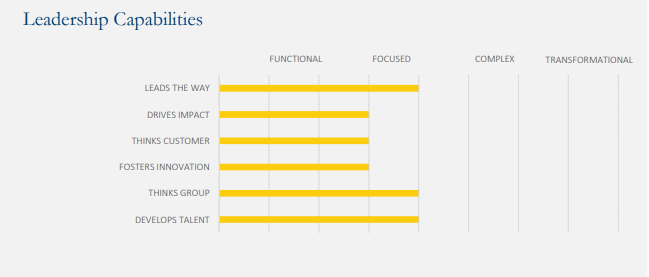

In [16]:
image_path = '/content/drive/MyDrive/freelance/1sample_graph.png'
# image_path = '/content/drive/MyDrive/freelance/1sample_graph_edited.png'
img = cv2.imread(image_path)
cv2_imshow(img)

### enhanced image

In [ ]:
# import requests
# response = requests.post(
#   'https://www.cutout.pro/api/v1/matting?mattingType=18',
#   files={'file': open(image_path, 'rb')},
#   headers={'APIKEY': '04c68d378bf84b71a63d7afe20ab20b1'},
# )
# with open('/content/output_images/out.png', 'wb') as out:
#   out.write(response.content)

# image_path = '/content/output_images/out.png'
# img = cv2.imread(image_path)
# cv2_imshow(img)

### contour detection (detection of bars from the bar graph)

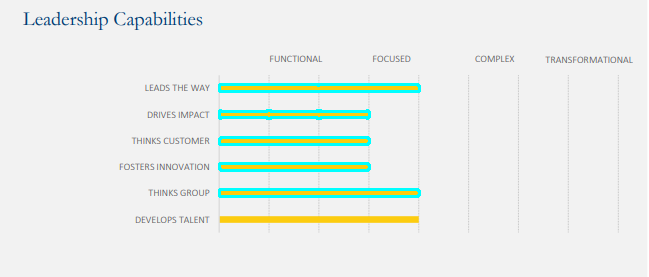

In [17]:
bars = calc_contours(image_path)
contours_right_coords = get_topright_corner(bars[::-1])





### getting the bboxes of the words

In [19]:
image = Image.open(image_path)

feature_extractor,tokenizer,model = loadFromLayoutlmv2()

id2label, label2color = labelForBoxes()


output_image, boxes,words,true_predictions,true_boxes,is_subword = process_image(image,id2label,label2color,feature_extractor,tokenizer,model)

words_to_bbox = merge_close_words(words,boxes,image)
bboxes = list(words_to_bbox.values())


/usr/local/lib/python3.9/dist-packages/transformers/models/layoutlmv2/feature_extraction_layoutlmv2.py:30: FutureWarning: The class LayoutLMv2FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv2ImageProcessor instead.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset funsd downloaded and prepared to /root/.cache/huggingface/datasets/nielsr___funsd/funsd/1.0.0/8b0472b536a2dcb975d59a4fb9d6fea4e6a1abe260b7fed6f75301e168cbe595. Subsequent calls will reuse this data.


### matching of contours with their respective values 

In [20]:
words_to_boxes = merge_close_words(words,boxes,image)
bboxes = list(words_to_boxes.values())
bboxes.insert(0, [0.0,0.0,0.0,0.0])
bboxes.append( [0.0,0.0,0.0,0.0])
words_d = [list(words_to_boxes.keys())]

updated_categorized_data = graph_categorizer(words_d,bboxes,image)
updated_words_to_bboxes = merge_close_words(words,boxes,image)
contours_right_coords = get_topright_corner(bars[::-1])

contour_to_values = nearest_assignment(updated_categorized_data,updated_words_to_bboxes,contours_right_coords)

sub_output = assign_value_to_keys(updated_categorized_data,updated_words_to_bboxes,contours_right_coords,contour_to_values)

### output

In [22]:
output = {"header": updated_categorized_data['headers'], "Mapping":sub_output}
output

{'header': ['Leadership Capabilities'],
 'Mapping': {'LEADS THE WAY': 'Focuseo',
  'Dives pact': 'Focuseo',
  '"THINKS CUSTOMER': 'Focuseo',
  'FOSTERS INNOVATION': 'Focuseo'}}

# Graph type II

In [23]:
!pip install pyyaml==5.1
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
!pip install -q pytesseract


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [24]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
!sudo apt-get install tesseract-ocr
!pip install -q pytesseract


Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [26]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pytesseract

from transformers import LayoutLMv2FeatureExtractor, LayoutLMv2TokenizerFast, LayoutLMv2ForTokenClassification
from datasets import load_dataset
from PIL import Image, ImageFont, ImageDraw


### function definitions

In [27]:
def get_condional_bbox(image_path):
  img = cv2.imread(image_path)


  # Convert the image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Apply a thresholding operation to convert the image to a binary image
  thresh_value = 60
  ret, thresh = cv2.threshold(gray, thresh_value, 255, cv2.THRESH_BINARY)

  # Find the contours in the binary image
  contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

  # filtering out the unwanted contours
  new_contours = []
  for cnt in contours:
      area = cv2.contourArea(cnt)
      x, y, w, h = cv2.boundingRect(cnt)
      aspect_ratio = float(w) / h
      if area < 100000  and area > 10000:
          new_contours.append(cnt)
  # Draw all the contours on a blank image
  contour_img = np.zeros_like(img)
  cv2.drawContours(contour_img, new_contours, -1, (0, 255, 0), 2)

  # Filterring out the unwanted contours again
  bboxes = [new_contours[0][idx].tolist()[0] for idx in range(len(new_contours[0])) if idx in [0,3,4,8]]

  return bboxes


In [28]:


def loadFromLayoutlmv2():
  feature_extractor = LayoutLMv2FeatureExtractor.from_pretrained("microsoft/layoutlmv2-base-uncased")# apply_ocr is set to True by default
  tokenizer = LayoutLMv2TokenizerFast.from_pretrained("microsoft/layoutlmv2-base-uncased") 
  model = LayoutLMv2ForTokenClassification.from_pretrained("nielsr/layoutlmv2-finetuned-funsd")
  return feature_extractor,tokenizer,model

def labelForBoxes():
  dataset = load_dataset("nielsr/funsd", split="test")
  # define id2label, label2color
  labels = dataset.features['ner_tags'].feature.names
  id2label = {v: k for v, k in enumerate(labels)}
  label2color = {'question':'blue', 'answer':'green', 'header':'orange', 'other':'violet'}
  return id2label, label2color

def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

def iob_to_label(label):
    label = label[2:]
    if not label:
      return 'other'
    return label

def process_image(image,id2label,label2color,feature_extractor,tokenizer,model):
    
    # Convert the image to RGB format
    image = image.convert('RGB')
    width, height = image.size

    # get words, boxes
    encoding_feature_extractor = feature_extractor(image, return_tensors="pt")
    words, boxes = encoding_feature_extractor.words, encoding_feature_extractor.boxes
    # encode
    encoding = tokenizer(words, boxes=boxes, truncation=True, return_offsets_mapping=True, return_tensors="pt")
    offset_mapping = encoding.pop('offset_mapping')
    encoding["image"] = encoding_feature_extractor.pixel_values
    # forward pass
    outputs = model(**encoding)
    # get predictions
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    token_boxes = encoding.bbox.squeeze().tolist()
    # only keep non-subword predictions
    is_subword = np.array(offset_mapping.squeeze().tolist())[:,0] != 0
    true_predictions = [id2label[pred] for idx, pred in enumerate(predictions) if not is_subword[idx]]
    true_boxes = [unnormalize_box(box, width, height) for idx, box in enumerate(token_boxes) if not is_subword[idx]]
    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(true_predictions, true_boxes):
        predicted_label = iob_to_label(prediction).lower()
        draw.rectangle(box, outline=label2color[predicted_label])
        draw.text((box[0]+10, box[1]-10), text=predicted_label, fill=label2color[predicted_label], font=font)
    return image,true_boxes,words,true_predictions,true_boxes,is_subword


In [29]:
def normalize_bbox(bboxes,img):
  
  # Define the new image size
  new_width = 100
  new_height = 100

  original_width,original_height = img.size
  # Calculate the scaling factors
  x_scale = new_width / original_width
  y_scale = new_height / original_height

  #parsing the bboxes
  new_bboxes = []
  for bbox in bboxes:
    x1,y1,x2,y2 = bbox
    # Normalize the bounding box coordinates
    new_x1 = int(x1 * x_scale)
    new_y1 = int(y1 * y_scale)
    new_x2 = int(x2 * x_scale)
    new_y2 = int(y2 * y_scale)

    new_bbox = new_x1,new_y1,new_x2,new_y2
    new_bboxes.append(new_bbox)
  return new_bboxes

In [30]:
######### categorize the words into "headers"

def get_the_header(words,bboxes,img):
  
  output_dict = {"headers":[],"values":[]}

  bboxes = normalize_bbox(bboxes,img)
  
  prev_y1 = bboxes[0][1]
  header = None
  for idx in range(len(words[0])):
    x1,y1,x2,y2 = bboxes[idx]
    ###### header
    diff = abs(prev_y1 - y1)
    if(diff>20):
      break
    if(header==None):
      header = words[0][idx]
      continue
    header = header + ' ' + words[0][idx]
    prev_y1 = y1
  return header

In [31]:
def words_inside_bbox(words,text_boxes,cond_bbox):
  c_x1 , c_y1, c_x2, c_y2 = float(cond_bbox[0][0]), float(cond_bbox[0][1]), float(cond_bbox[1][0]),float(cond_bbox[2][1])
  # print(c_x1 , c_y1, c_x2, c_y2,'\n\n')
  out_word = None
  ## parse the words
  for idx in range(len(words)):
    x1,y1,x2,y2 = text_boxes[idx]
    x1,y1,x2,y2 = round(x1,2),round(y1,2),round(x2,2),round(y2,2)
    # print(words[idx], x1,y1,x2,y2)

    # x1>=c_x1 and x2<=c_x2 and y1>=c_y1 and y2<=c_y2
    if(x1>=c_x1 and x2<=c_x2 and y1>=c_y1 and y2<=c_y2):
        # print(words[idx], x1,y1,x2,y2 )
        if(out_word==None):
          out_word = words[idx]
          continue
        out_word += " " + words[idx]

  # print(out_word)
  return out_word

### input image

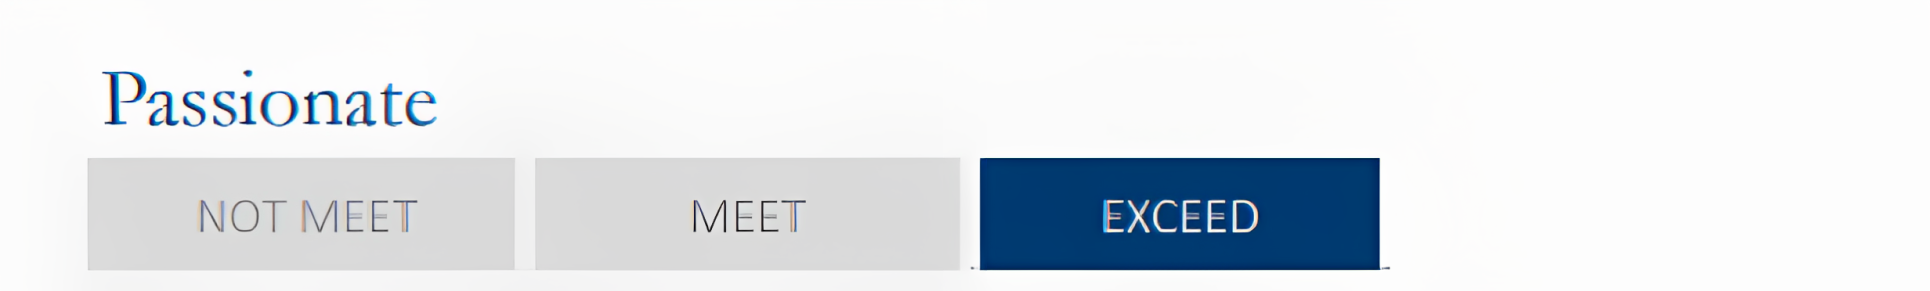

In [44]:
# Load the image
image_path = '/content/drive/MyDrive/freelance/graph_2/1sample_graph_enhanced.png'  # (535, 1051, 3)
image_path = '/content/drive/MyDrive/freelance/graph_2/global_market_benchmark_enhanced.png' # (328, 1711, 3)
image_path = '/content/drive/MyDrive/freelance/graph_2/leadership_capability_enhanced.png'
image_path = '/content/drive/MyDrive/freelance/graph_2/passionate_enhanced.png'
# image_path =
image = Image.open(image_path)
image

### image enhancement

In [40]:
try:
  import os
  os.mkdir('/content/output_images')
except:
  pass

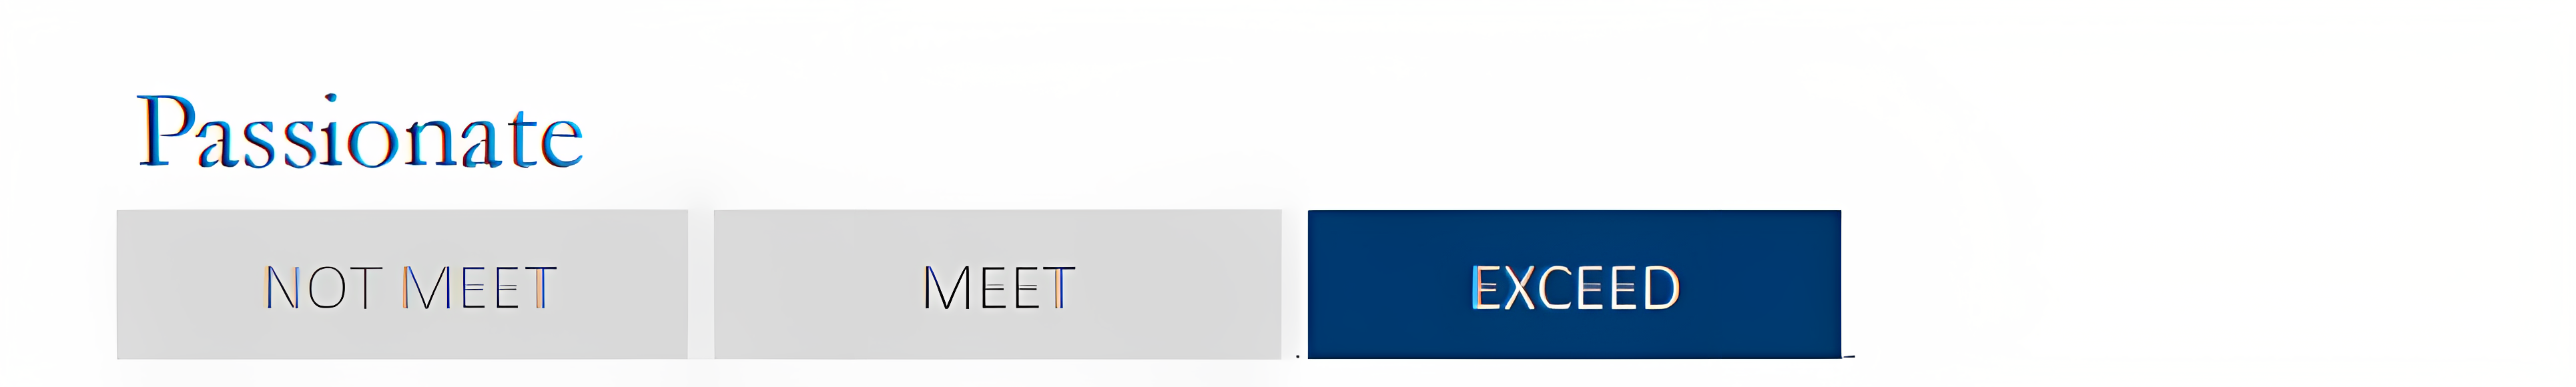

In [41]:
import requests
response = requests.post(
  'https://www.cutout.pro/api/v1/matting?mattingType=18',
  files={'file': open(image_path, 'rb')},
  headers={'APIKEY': '04c68d378bf84b71a63d7afe20ab20b1'},
)
with open('/content/output_images/out.png', 'wb') as out:
  out.write(response.content)

image_path = '/content/output_images/out.png'
img = cv2.imread(image_path)
cv2_imshow(img)

### get the bboxes of most dark rectangle

In [45]:

cond_boxes = get_condional_bbox(image_path)

### get the bboxes of all the text 

In [46]:
output_image, boxes,words,true_predictions,true_boxes,is_subword = process_image(image,id2label,label2color,feature_extractor,tokenizer,model)
boxes = boxes[1:-1]

### filter out the text that lies under the bbox detected in first step

In [47]:
output_word = words_inside_bbox(words[0],boxes,cond_boxes)

header = get_the_header(words,boxes,image)



### output

In [48]:
output = {header:output_word}
output

{'Passionate': 'EXCEED'}